# Hackathon - Cortex seq-FISH + scRNA data - gene selection challenge
> Analysis of [seqFISH challenge](https://github.com/BIRSBiointegration/Hackathon/tree/master/seqFISH) for the [BIRS Biointegration workshop](http://www.birs.ca/videos/2020).
> This repo is focusing on one challenge question: what is the minimal number of genes needed for data integration. To integrate the two omics data, the key information we need to know is what types of cells are there and which spatial coordinates do they map to.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [seqFish, scRNA]
- hide: false

### Background

This study integrates sequencing and imaging-based single-cell transcriptomic profiling methods. The authors showed that the incorporation of scRNAseq data improved cell-type mapping using seqFISH data analysis alone while including the seqFISH data enabled the identification of spatial structure in the scRNAseq data (Figure from Zhu *et al* 2018). For our workshop, we focus on a subset of these data that contain matched seqFISH and scRNAseq data for the adult mouse visual cortex.

#### Key articles

Zhu *et al* 2018, reference paper for seqFISH is available at: (https://www.nature.com/articles/nbt.4260)

Tasic *et al* 2016, reference paper for scRNAseq is available at: (https://www.nature.com/articles/nn.4216)

### Main
#### Dependency

- python 3
- python packages:
  - scanpy (v1.4.5.1)
  - numpy (v1.18.1)
  - pandas (v1.0.1)
  - matplotlib (v3.1.3)
  - seaborn (v0.10.1)
  - scikit-learn (v0.22.1)
  - yellowbrick (v1.1)

#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC


#### Define functions

In [2]:
def read_genes(fn):
    f = open(fn)
    next(f)
    genes = []
    for l in f:
        l = l.rstrip("\n")
        ll = l.split("\t")
        genes.append(ll[0])
    f.close()
    return genes

def eva_model(c, n, X, y, X_test, y_test, class_names, outdir):
    model = svm.LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=c)
    rfe = RFE(model, n_features_to_select=n)

    ## learning curve
    plt.clf()
    viz_LC = LearningCurve(
        rfe, scoring='f1_weighted', n_jobs=4
    )
    viz_LC.fit(X, y)
    viz_LC.show(outpath=outdir + '/LC.png')

    ## classification report
    plt.clf()
    viz_CR = ClassificationReport(rfe, classes=class_names, support=True)
    viz_CR.fit(X, y)
    viz_CR.score(X_test, y_test)
    viz_CR.show(outpath=outdir + '/CR.png')

    ## confusion matrix
    plt.clf()
    viz_CM = ConfusionMatrix(rfe, classes=class_names)
    viz_CM.fit(X, y)
    viz_CM.score(X_test, y_test)
    viz_CM.show(outpath=outdir + '/CM.png')

    ## precision recall curve
    plt.clf()
    viz_PRC = PrecisionRecallCurve(rfe, per_class=True, iso_f1_curves=True,
                                   fill_area=False, micro=False, classes=class_names)
    viz_PRC.fit(X, y)
    viz_PRC.score(X_test, y_test)
    viz_PRC.show(outpath=outdir + '/PRC.png',size=(1080,720))

    ## class prediction error
    plt.clf()
    viz_CPE = ClassPredictionError(
        rfe, classes=class_names
    )
    viz_CPE.fit(X, y)
    viz_CPE.score(X_test, y_test)
    viz_CPE.show(outpath=outdir + '/CPE.png')

    ## ROCAUC
    plt.clf()
    viz_RA = ROCAUC(rfe, classes=class_names, size=(1080,720))
    viz_RA.fit(X, y)
    viz_RA.score(X, y)
    viz_RA.show(outpath=outdir + '/RA.png')

    fit = rfe.fit(X,y)
    y_predict = fit.predict(X_test)
    f1 = f1_score(y_test, y_predict, average='weighted')

    features_retained_RFE = X.columns[rfe.get_support()].values
    feature_df =pd.DataFrame(features_retained_RFE.tolist())
    feature_df.to_csv(outdir + '/features.csv', sep='\t', index=False)

    return f1

#### Read files

In [3]:
#### files ######

## high variable genes
genes_fn = '../rsc/highly_variable_genes.tsv'

## scRNA
## txt file of normalized scRNAseq data for 113 genes x 1723 cells
scrna_data_fn = '../rsc/tasic_scRNAseq/tasic_training_b2.txt'

## tsv file of cell type labels for scRNAseq
scrna_label_fn = '../rsc/tasic_scRNAseq/tasic_labels.tsv'

## seqFish
## txt file of normalized seqFISH data for 113 genes x 1597 cells
seqfish_data_fn = '../rsc/tasic_scRNAseq/seqfish_cortex_b2_testing.txt'

## tsv file of spatial cluster labels and SVM learned cell types for seqFISH
seqfish_label_fn = '../rsc/tasic_scRNAseq/seqfish_labels.tsv'

######### read files ###########

var_genes = read_genes(genes_fn)

scrna_expr = pd.read_csv(scrna_data_fn, sep='\t', header=None, index_col=0)
scrna_label = pd.read_csv(scrna_label_fn, sep='\t', header=None)

seqfish_expr = pd.read_csv(seqfish_data_fn, sep='\t', header=None, index_col=0)
seqfish_label = pd.read_csv(seqfish_label_fn, sep='\t', header=None)

#### filter scRNA data to high variable genes ###


In [4]:
X = scrna_expr.T.reset_index()[var_genes]
y = scrna_label[0]
X_test = seqfish_expr.T.reset_index()[var_genes]
y_test = seqfish_label[2]



#### store cell type names

In [5]:
class_names = ['Astrocyte',
               'Endothelial Cell',
               'GABA-ergic Neuron',
               'Glutamatergic Neuron',
               'Microglia',
               'Oligodendrocyte.1',
               'Oligodendrocyte.2',
               'Oligodendrocyte.3']



#### Gene Selection
To find out what is the minimal number of genes needed, we recursively train an SVM classification model using a different number of genes and evaluate the performance using cross-validation. This process is done using function 'eva_model' which performs the 'Recursive Feature Elimination (RFE)' method.
Here we perform and plot the performance of the SVM classification models with different C settings.


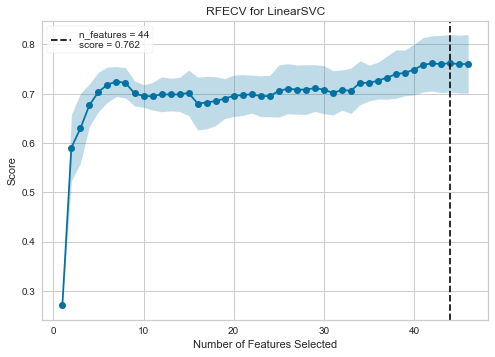

In [6]:
c = 1e-6
model = svm.LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=c)
viz = RFECV(model, scoring='f1_weighted')
viz.fit(X, y)
viz.show()

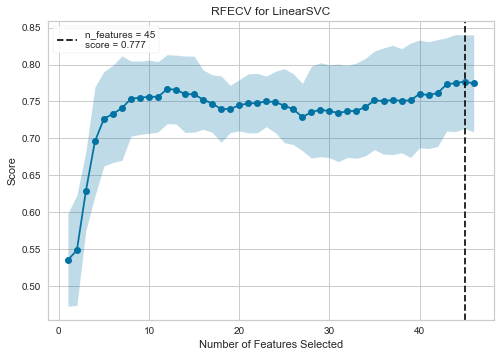

In [7]:
c = 1e-3
model = svm.LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=c)
viz = RFECV(model, scoring='f1_weighted')
viz.fit(X, y)
viz.show()

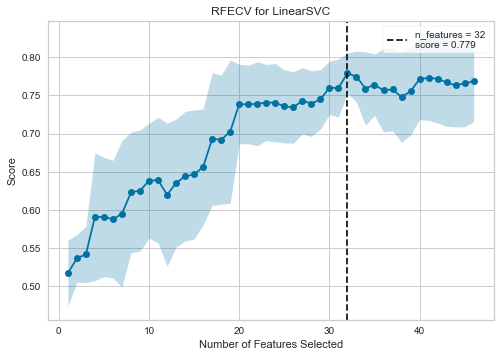

In [9]:
c = 1
model = svm.LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=c)
viz = RFECV(model, scoring='f1_weighted')
viz.fit(X, y)
viz.show()

In [ ]:
## plot RFECV for LinearSVC
for c in [1e-6, 1e-3, 1]:
    model = svm.LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=c)
    viz = RFECV(model, scoring='f1_weighted')
    viz.fit(X, y)
    viz.show()